AI Programming - (c) SW Lee

# Lab 08: Deep Q Learning Network (a.k.a DQN)
## Exercise: Cart Pole, Lunar Lander

### Prepare Library Packages

In [ ]:
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython())

# To prevent that some version of matplolib causes an openmp error
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
if RunningInCOLAB:
    !pip install swig
    !pip install gymnasium==0.26.3
    !pip install gymnasium[box2d]
    !pip install pygame
    !pip install 'moviepy>=1.0.3'
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 19.5 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373076 sha256=eb478d3a9bfe4eaa11f32787a3c222725743cf1a32ab65d6b382e8d2ab0fb28a
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gymnasium as gym
from gymnasium import wrappers

from collections import deque
import random

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('GPU is not detected.')

[]
GPU is not detected.


In [ ]:
gym.__version__

'0.26.3'

### Select Environment

**Cart Pole**<br>
https://gymnasium.farama.org/environments/classic_control/cart_pole/

**Lunar Lander**<br>
https://gymnasium.farama.org/environments/box2d/lunar_lander/

In [ ]:
# select evironment
# Discrete Action Space:    0 for Cartpole, 1 for LunarLander

SELECT_ENV = 0

In [ ]:
if SELECT_ENV == 0:
    env_name, res_prefix = 'CartPole-v1', 'cart'
    max_episodes, max_ep_steps, goal_score = 500, 500, 450
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0
    kwargs = {'render_mode':'rgb_array'}
elif SELECT_ENV == 1:
    env_name, res_prefix = 'LunarLander-v2', 'lunD'
    max_episodes, max_ep_steps, goal_score = 500, 1000, 200
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0
    kwargs = {'continuous':False, 'render_mode':'rgb_array'}
else: assert False, 'environment selection error'

def create_env():
    env = gym.make(env_name, **kwargs)
    return env

You can modify reward if you want to converge fast by adding the following at the bottom:

`if SELECT_ENV == 0 and done: reward = -1 # modification for cartpole`


In [ ]:
def env_reset(env):
    observation = env.reset()
    state = observation[0] if type(observation)==tuple else observation
    return state

def env_step(env, action):
    observation = env.step(action)
    state = observation[0]
    reward = observation[1]
    done = observation[2] or observation[3] if len(observation)>4 else observation[2]
    return state, reward, done

In [ ]:
env = create_env()
state = env_reset(env)
state, reward, done = env_step(env, env.action_space.sample())

### Check and Show Environment Variables

In [ ]:
action_shape = env.action_space.shape
action_space_type = type(env.action_space)

if action_space_type==gym.spaces.discrete.Discrete:
    actn_space = 'DISCRETE'
    action_shape = (1,)
    action_dims = 1
    action_range = env.action_space.n
    num_actions = action_range  # number of actions is action range for DISCRETE actions
    action_batch_shape = (None, action_range)
elif action_space_type==gym.spaces.box.Box:
    actn_space = 'CONTINUOUS'
    action_dims = action_shape[0]
    actn_uppr_bound = env.action_space.high[0]
    actn_lowr_bound = env.action_space.low[0]
    action_range = (actn_uppr_bound - actn_lowr_bound) # x0.5 for tanh output
    action_batch_shape = tuple([None]+[x for x in action_shape])
    num_actions = action_dims   # number of actions is action dimension for CONTINUOUS actions
else: assert False, 'other action space type are not supported'

observation_space_type = type(env.observation_space)
observation_shape = env.observation_space.shape

if observation_space_type==gym.spaces.discrete.Discrete:
    observation_shape = (1,)
    num_states = env.observation_space.n
elif observation_space_type==gym.spaces.box.Box:
    num_states = observation_shape[0]
else: print('observation space type error')

if SELECT_ENV == 2 or SELECT_ENV == 3 or SELECT_ENV == 4 or SELECT_ENV == 7:
    state_shape = (96,96,3)
    state_batch_shape = (None,96,96,3)
else:
    state_shape = observation_shape
    state_batch_shape = tuple([None]+[x for x in observation_shape])

value_shape = (1,)
num_values = 1

In [ ]:
print('Action space ', action_space_type)
print('Action shape ', action_shape)
print('Action dimensions ', action_dims)
print('Action range ', action_range)
if action_space_type==gym.spaces.box.Box:
    print('Max Value of Action ', actn_uppr_bound)
    print('Min Value of Action ', actn_lowr_bound)
else: pass
print('Action batch shape ', action_batch_shape)

print('Observation space ', observation_space_type)
print('Observation shape ', observation_shape)
print('Size of State Space ', num_states)
print('State shape ', state_shape)
print('State batch shape ', state_batch_shape)

print('Vallue shape ', value_shape)
print('Value dimensions ', num_values)

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  2
Action batch shape  (None, 2)
Observation space  <class 'gymnasium.spaces.box.Box'>
Observation shape  (4,)
Size of State Space  4
State shape  (4,)
State batch shape  (None, 4)
Vallue shape  (1,)
Value dimensions  1


### Define and Initialize The Agent
### **Exercise:** Define Deep Q-network (TensorFlow)

A NN of three fully-connected layers is enough for classic control problems.<br>

**Parameters for layer definition are:**<br>
hiddens = (unit # for layer1, unit # for layer2),<br>
act_fn: activation function,<br>
out_fn: activation function for output layer, <br>
init_fn: kernel initialization function

In [ ]:
def DQNet(hiddens, act_fn, out_fn, init_fn):    # hiddends = (layer1 units, layer2 units)
    inputs = tf.keras.Input(shape=state_shape)  # input layer

    l1_units, l2_units = hiddens                                                                          # decoding hiddens
    # each layer parameter , units, act_fn, init_fn
    l1 = tf.keras.layers.Dense(units=l1_units, activation=act_fn, kernel_initializer=init_fn)(inputs)     # first fully connected layer
    l2 = tf.keras.layers.Dense(units=l2_units, activation=act_fn, kernel_initializer=init_fn)(l1)         # second fully connected layer
    outputs = tf.keras.layers.Dense(units=num_actions, activation=out_fn, kernel_initializer=init_fn)(l2) # output

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='q_net')
    return model

def build_DQNet():
    model = DQNet(hiddens=(32,32), act_fn='relu', out_fn='linear', init_fn='he_uniform')
    return model

The policy function in the Agent_Net is just for getting a SINGLE sample, not for training. So you have to set `training=False` if necessary.
Since the network takes batch format (i.e., `[batch,data]`), the input state should be given as `[None,...]` and the output should be taken as `[0,...]`.

### **Exercise:** Define Policy Functions

In [ ]:
class Agent_Net:
    def __init__(self):
        self.policy_q = build_DQNet()                       # build policy network
        self.target_q = build_DQNet()                       # build target network
        self.target_update()                                # copy weights from policy to target

    def policy(self, state, epsilon, exploring):            # e-greedy policy if exploring==True
        state_input = tf.convert_to_tensor(state[None,...], dtype=tf.float32)   # make the state network-ready

        if exploring:                                         # if e-greedy policy
            if np.random.rand() > epsilon:                    # exploit if random>epsilon
                action_q = self.policy_q(state_input)         # compute q_value in policy
                action = tf.argmax(action_q, axis=1)[0]       # get action for maximum q value
            else:                                             # not explore
                action = np.random.randint(0,action_range)    # chose random action
                action = tf.convert_to_tensor(action)         # change format
        else:                                                 # greedy policy (not exploit)
            action_q = self.policy_q(state_input)             # get actions for input state
            action = tf.argmax(action_q, axis=1)[0]           # get action for maximum q value

        return action.numpy()

    def target_update(self):
        self.target_q.set_weights(self.policy_q.get_weights())  # copy weights from policy network to target network
        return

In [ ]:
agent = Agent_Net()
agent.policy_q.summary()

Model: "q_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_6 (Dense)             (None, 32)                160       
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Define and Initialize Replay Memory

The replay memory (or replay buffer) is implemented with `deque`, which maintians the fixed number of elements by discarding the oldest element automatically.<br>
The inputs of the `put_experience` function are from environments and the outputs of the `get_batch` function are fed to the NN. Therefore the output types should be tensors.

In [ ]:
class ReplayMemory:
    def __init__(self, memory_size):
        self.experiences = deque(maxlen=memory_size)    # allocate replay memory
        self.num_episodes = 0                           # set number of episode to zero

    def put_experience(self, experience):               # put an experience into replay memory
        state, action, next_state, reward, not_done = experience
        self.experiences.append((state, action, next_state, reward, not_done))
        return

    def get_batch(self, num_samples):                   # get a batch of randomly sampled experiences
        state_batch, next_state_batch, action_batch, reward_batch, not_done_batch = [], [], [], [], []

        sample_batch = random.sample(self.experiences, num_samples)

        for sample in sample_batch:
            state, action, next_state, reward, not_done = sample
            state_batch.append(state)
            action_batch.append(action)
            next_state_batch.append(next_state)
            reward_batch.append(reward)
            not_done_batch.append(not_done)

        batch = (tf.convert_to_tensor(state_batch, dtype=tf.float32),
                tf.convert_to_tensor(action_batch, dtype=tf.int32),
                tf.convert_to_tensor(next_state_batch, dtype=tf.float32),
                tf.convert_to_tensor(reward_batch, dtype=tf.float32),
                tf.convert_to_tensor(not_done_batch, dtype=tf.float32))
        return batch

### **Exercise:** Initialize the replay memory

A single experience consists of `(state, action, next_state, reward, not_done)`. Be careful with **`not_done`**.

In [ ]:
def init_memory(mem, env, agent, num_samples):
    state = env_reset(env)                                               # initialize environment
    for _ in range(num_samples):

        action = agent.policy(state, epsilon=1, exploring = True)     # get an action with the policy
        next_state, reward, done = env_step(env, action)              # after action observe the environment outcome
        experience = (state, action, next_state, reward, not done)    # packing experience tuple
        mem.put_experience(experience)                                # put the experience to replay memory
        state = next_state if not done else env_reset(env)                # update state

    return

### Learning Procedures

DQN trains the Q-network to minimize the difference:

$$ \delta_t = (r_{t} + \gamma \max_{\hat{a}_{t+1}} Q_T(s_{t+1}, \hat{a}_{t+1}; \theta_T)) - Q_P(s_t, a_t; \theta_P) $$

where $Q_T$ is a target network and $Q_P$ policy network.

Then the loss function is

$$ L(\theta_P) = \delta_t^2 $$

### **Exercise:** Define ONE step of Training Loop and Evaluation Loop

In [ ]:
def dqn_train(agent, batch, config):
    state_b, action_b, next_state_b, reward_b, not_done_b = batch

    curr_q = agent.policy_q(state_b)                                   # get q_value with current policy
    next_q = agent.target_q(next_state_b)                              # get q_value with target policy
    max_next_q = tf.reduce_max(next_q, axis=1)                         # conput max Q value
    target_reward = reward_b + config.gamma* max_next_q * not_done_b   # calculate target reward
    target_reward = tf.expand_dims(target_reward, axis = -1)
    action_v = tf.one_hot(action_b,action_range)                       # make one-hot encoded
    label_q = (1-action_v) * curr_q + action_v * target_reward         # make ground true labels for training (b,a)
    logs = agent.policy_q.fit(state_b,label_q)                         # training policy

    loss = logs.history['loss'][-1]
    return loss

In [ ]:
def evaluate_policy(env, agent, num_avg):

    total_reward = 0.0
    episodes_to_play = num_avg
    for i in range(episodes_to_play): # Play n episode and take the average
        state = env_reset(env)
        done = False
        episode_reward = 0.0
        while not done:

            action = agent.policy(state, epsilon=0, exploring = False)  # get an action with policy
            next_state, reward, done = env_step(env, action)            # after action observe the environment outcome

            state = next_state
            episode_reward += reward
        total_reward += episode_reward
    average_reward = total_reward / episodes_to_play

    return average_reward

### Define Epsilon Function

This is an example of exponential decay epsilon function. One of easist epsilon decay functions is simply to multiply 0.9. You can define your own epsilon function.

In [ ]:
# Exploration parameters for epsilon greedy strategy
class Epsilon:
    def __init__(self, max_steps):
        self.explore_start = 1.0            # exploration probability at start
        self.explore_stop = 0.01            # minimum exploration probability
        self.decay_rate = 20.0/max_steps    # exponential decay rate for exploration prob (4.6 ~ max_step)
        self.steps = 0

    def get_epsilon(self):
        eps = (self.explore_stop
            + (self.explore_start - self.explore_stop) * tf.math.exp(-self.decay_rate * self.steps))
        self.steps += 1
        return eps

### Define and Initialize Hyperparameters


In [ ]:
class configuration:
    def __init__(self):
        self.gamma = 0.99   # discount rate
        self.lr = 1e-3      # learning rate

config = configuration()

In [ ]:
max_episodes = 500
max_steps = 30000
batch_size = 128

memory_size = 2000

memD = ReplayMemory(memory_size)
init_memory(memD, env, agent, 1000)
epsF = Epsilon(max_steps)

agent.policy_q.compile(optimizer=tf.optimizers.Adam(learning_rate=config.lr), loss='mse')

Moviepy - Building video /content/gym-results/cart-episode-1.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-1.mp4


Moviepy - Building video /content/gym-results/cart-episode-8.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-8.mp4


Moviepy - Building video /content/gym-results/cart-episode-27.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-27.mp4


### Define Main Training Loop


### **Exercise:** Complete Main Training Loop

In [ ]:
logs = tf.keras.callbacks.History()
logs.history.update({'pi_loss':[]})
logs.history.update({'ereward':[]})
logs.history.update({'e-steps':[]})
logs.history.update({'vreward':[]})

# variables for simulation
num_episodes = 0
val_episodes = 5            # exit condition

# variables for episode logging
pi_loss = 0.0

loss_sum = 0.0
epis_steps = 0
epis_reward = 0.0
eval_reward = -float('inf')

# initialize training variables
epsilon = 1.0
next_state = None
done = True

pbar = tqdm(range(max_steps), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

for sim_steps in pbar:

    # get the current state
    state =env_reset(env) if done else next_state
    action = agent.policy(state, epsilon, exploring=True)
    next_state, reward, done = env_step(env, action)

    # Save experience in replay memory
    experience = (state, action, next_state, reward, not done)
    memD.put_experience(experience)

    # Make batch of experience randomly sampled form replay memory
    batch = memD.get_batch(batch_size)
    step_pi_loss = dqn_train(agent, batch, config)  # training

    # update decay epsilon value
    epsilon = epsF.get_epsilon()

    loss_sum += step_pi_loss                                # accumulate policy loss for a step
    epis_reward += reward                                   # accumulate reward for a step
    epis_steps += 1                                         # increase the number of steps for an episode

    if done:
        agent.target_update()                               # update target network whenever episode ends
        memD.num_episodes += 1                              # increase number of episode simulated

        pi_loss = loss_sum / epis_steps                     # average policy loss for an episode

        pbar.set_postfix({'episode':num_episodes, 'loss':step_pi_loss, 'reward':eval_reward, 'steps':epis_steps, 'evaluating':val_episodes})
        eval_reward = evaluate_policy(env, agent, 1)        # evaluate policy one time

        logs.history['pi_loss'].extend([pi_loss])
        logs.history['ereward'].extend([epis_reward])
        logs.history['e-steps'].extend([epis_steps])
        logs.history['vreward'].extend([eval_reward])

        loss_sum = 0.0
        epis_reward = 0.0
        epis_steps = 0
        num_episodes += 1

    else: pass

    pbar.set_postfix({'episode':num_episodes, 'loss':step_pi_loss, 'reward':eval_reward, 'steps':epis_steps})

    # coditions to stop simulation
    if eval_reward > goal_score:
        eval_reward = evaluate_policy(env, agent, val_episodes) # evaluate policy multiple times
    if eval_reward > goal_score: break
    if num_episodes > max_episodes: break

print('episodes:{0:5d}, loss:{1:7.5f}, val_reward {2:4.2f}'.format(num_episodes, pi_loss, eval_reward))
print('total steps:', sim_steps+1)


  0%|          | 0/30000 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step - loss: 0.4981
Moviepy - Building video /content/gym-results/cart-episode-64.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-64.mp4




t:   0%|          | 0/16 [00:00<?, ?it/s, now=None]
                                                   

Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-64.mp4
4/4 [==============================] - 0s 4ms/step - loss: 0.4633
episodes:   12, loss:0.69602, val_reward 487.40
total steps: 278


### Plot Training Histories

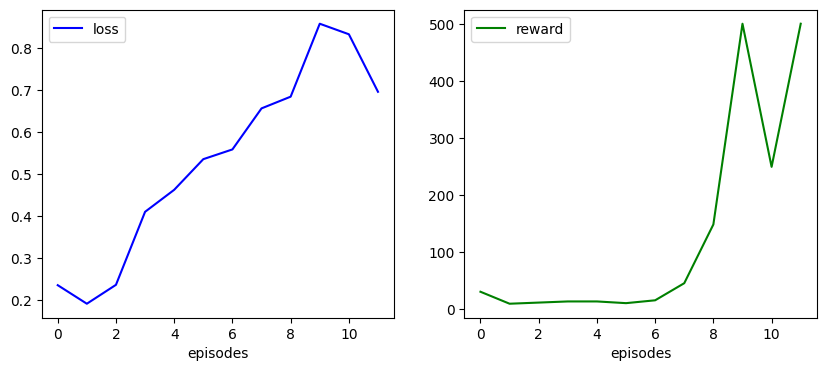

In [ ]:
# plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']):
    num_graphs = len(log_labels)
    plt.figure(figsize=(5*num_graphs,4))
    for i in range(num_graphs):
        plt.subplot(1,num_graphs,i+1)
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i])
        plt.xlabel('episodes')
        plt.legend()
    plt.show()
    return

log_labels    = ['pi_loss', 'vreward']
label_strings = ['loss', 'reward']
label_colors  = ['b-', 'g-']
plot_graphs(logs.history, log_labels, label_strings, label_colors)

### Evaluate the Agent

Since a single evaluation try often takes some time, evaluate the agent here to show the progress bar

In [ ]:
evaluate_episodes = 20
sum_episode_rewards = 0.0
pbar = tqdm(range(evaluate_episodes))

for i in pbar:
    sum_episode_rewards += evaluate_policy(env, agent, 1)

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes)

  0%|          | 0/20 [00:00<?, ?it/s]

Moviepy - Building video /content/gym-results/cart-episode-1.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-1.mp4




t:  97%|█████████▋| 484/501 [00:02<00:00, 221.37it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-1.mp4
Moviepy - Building video /content/gym-results/cart-episode-8.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-8.mp4




t:  96%|█████████▌| 483/502 [00:02<00:00, 225.06it/s, now=None]
                                                               

Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-8.mp4
Evaluation Result: 498.55


## Show How The Agent Works

In [ ]:
env.close()

env = create_env()
env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix)

eval_reward = evaluate_policy(env, agent, 1)

print('Sample Total Reward:', eval_reward)

env.close()

Moviepy - Building video /content/gym-results/cart-episode-0.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-0.mp4
Sample Total Reward: 500.0


In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 320):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video('./gym-results/' + res_prefix + '-episode-0.mp4')